# Eigenvalue Tracking During Training

This notebook compares Shampoo and Muon optimizers by tracking the eigenvalues of the weight matrix during training. 


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## Import Optimizers


In [2]:
# Import Muon and Shampoo optimizers
import sys
sys.path.append('.')

from muon import Muon, zeropower_via_newtonschulz5
from shampoo import Shampoo

print("Optimizers imported successfully!")


/Users/mahyarjafari/miniforge3/envs/torch_env/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mahyarjafari/miniforge3/envs/torch_env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/mahyarjafari/miniforge3/envs/torch_env/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/mahyarjafari/miniforge3/envs/torch_env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mahyarjafari/miniforge3/envs/torch_env/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mahyarjafari/miniforge3/envs/torch_env/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mahyarjafari/miniforge3/envs/torch_env/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Optimizers imported successfully!


## Define Simple 1-Layer Neural Network


In [3]:
class SimpleLinearNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=True)
        
    def forward(self, x):
        return self.linear(x)
    
    def get_weight_eigenvalues(self):
        """Compute eigenvalues of W^T W where W is the weight matrix"""
        W = self.linear.weight.data.cpu()
        # For rectangular matrices, compute eigenvalues of W^T W (or W W^T for smaller dim)
        if W.shape[0] <= W.shape[1]:
            gram = W @ W.T
        else:
            gram = W.T @ W
        eigenvalues = torch.linalg.eigvalsh(gram)
        return eigenvalues.numpy()

print("Model class defined!")


Model class defined!


## Generate Random Dataset


In [4]:
# Dataset parameters
n_samples = 1000
input_dim = 50
output_dim = 10
batch_size = 32

# Generate random dataset
X_train = torch.randn(n_samples, input_dim)
y_train = torch.randint(0, output_dim, (n_samples,))

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset created: {n_samples} samples, input_dim={input_dim}, output_dim={output_dim}")


Dataset created: 1000 samples, input_dim=50, output_dim=10


## Training Function with Eigenvalue Tracking


In [5]:
def train_and_track_eigenvalues(model, optimizer, train_loader, n_epochs, track_every=5):
    """
    Train the model and track eigenvalues of the weight matrix.
    
    Args:
        model: Neural network model
        optimizer: Optimizer instance
        train_loader: DataLoader for training
        n_epochs: Number of epochs to train
        track_every: Track eigenvalues every N steps
    
    Returns:
        eigenvalue_history: List of eigenvalues at each tracking step
        loss_history: List of losses
    """
    model.train()
    eigenvalue_history = []
    loss_history = []
    step = 0
    
    # Track initial eigenvalues
    eigenvalue_history.append(model.get_weight_eigenvalues())
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            step += 1
            
            # Track eigenvalues periodically
            if step % track_every == 0:
                eigenvalue_history.append(model.get_weight_eigenvalues())
        
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    return eigenvalue_history, loss_history

print("Training function defined!")


Training function defined!


## Train with Shampoo Optimizer


In [6]:
print("Training with Shampoo optimizer...")

# Create model and optimizer
model_shampoo = SimpleLinearNet(input_dim, output_dim).to(device)
optimizer_shampoo = Shampoo(model_shampoo.parameters(), lr=0.01, momentum=0.9)

# Train and track
eigenvalues_shampoo, loss_shampoo = train_and_track_eigenvalues(
    model_shampoo, 
    optimizer_shampoo, 
    train_loader, 
    n_epochs=50,
    track_every=5
)

print(f"\nShampoo training complete! Tracked {len(eigenvalues_shampoo)} eigenvalue snapshots.")


Training with Shampoo optimizer...
Epoch 10/50, Loss: 2.3987
Epoch 20/50, Loss: 2.3897
Epoch 30/50, Loss: 2.3706
Epoch 40/50, Loss: 2.3597
Epoch 50/50, Loss: 2.3520

Shampoo training complete! Tracked 321 eigenvalue snapshots.


## Train with Muon Optimizer


In [7]:
print("Training with Muon optimizer...")

# Reset random seed to get same initial weights
torch.manual_seed(42)

# Create model and optimizer
model_muon = SimpleLinearNet(input_dim, output_dim).to(device)
optimizer_muon = Muon(model_muon.parameters(), lr=0.01, momentum=0.9)

# Train and track
eigenvalues_muon, loss_muon = train_and_track_eigenvalues(
    model_muon, 
    optimizer_muon, 
    train_loader, 
    n_epochs=50,
    track_every=5
)

print(f"\nMuon training complete! Tracked {len(eigenvalues_muon)} eigenvalue snapshots.")


Training with Muon optimizer...
Epoch 10/50, Loss: 2.3774
Epoch 20/50, Loss: 2.3148
Epoch 30/50, Loss: 2.2736
Epoch 40/50, Loss: 2.2181
Epoch 50/50, Loss: 2.1726

Muon training complete! Tracked 321 eigenvalue snapshots.


## Visualize Eigenvalue Evolution


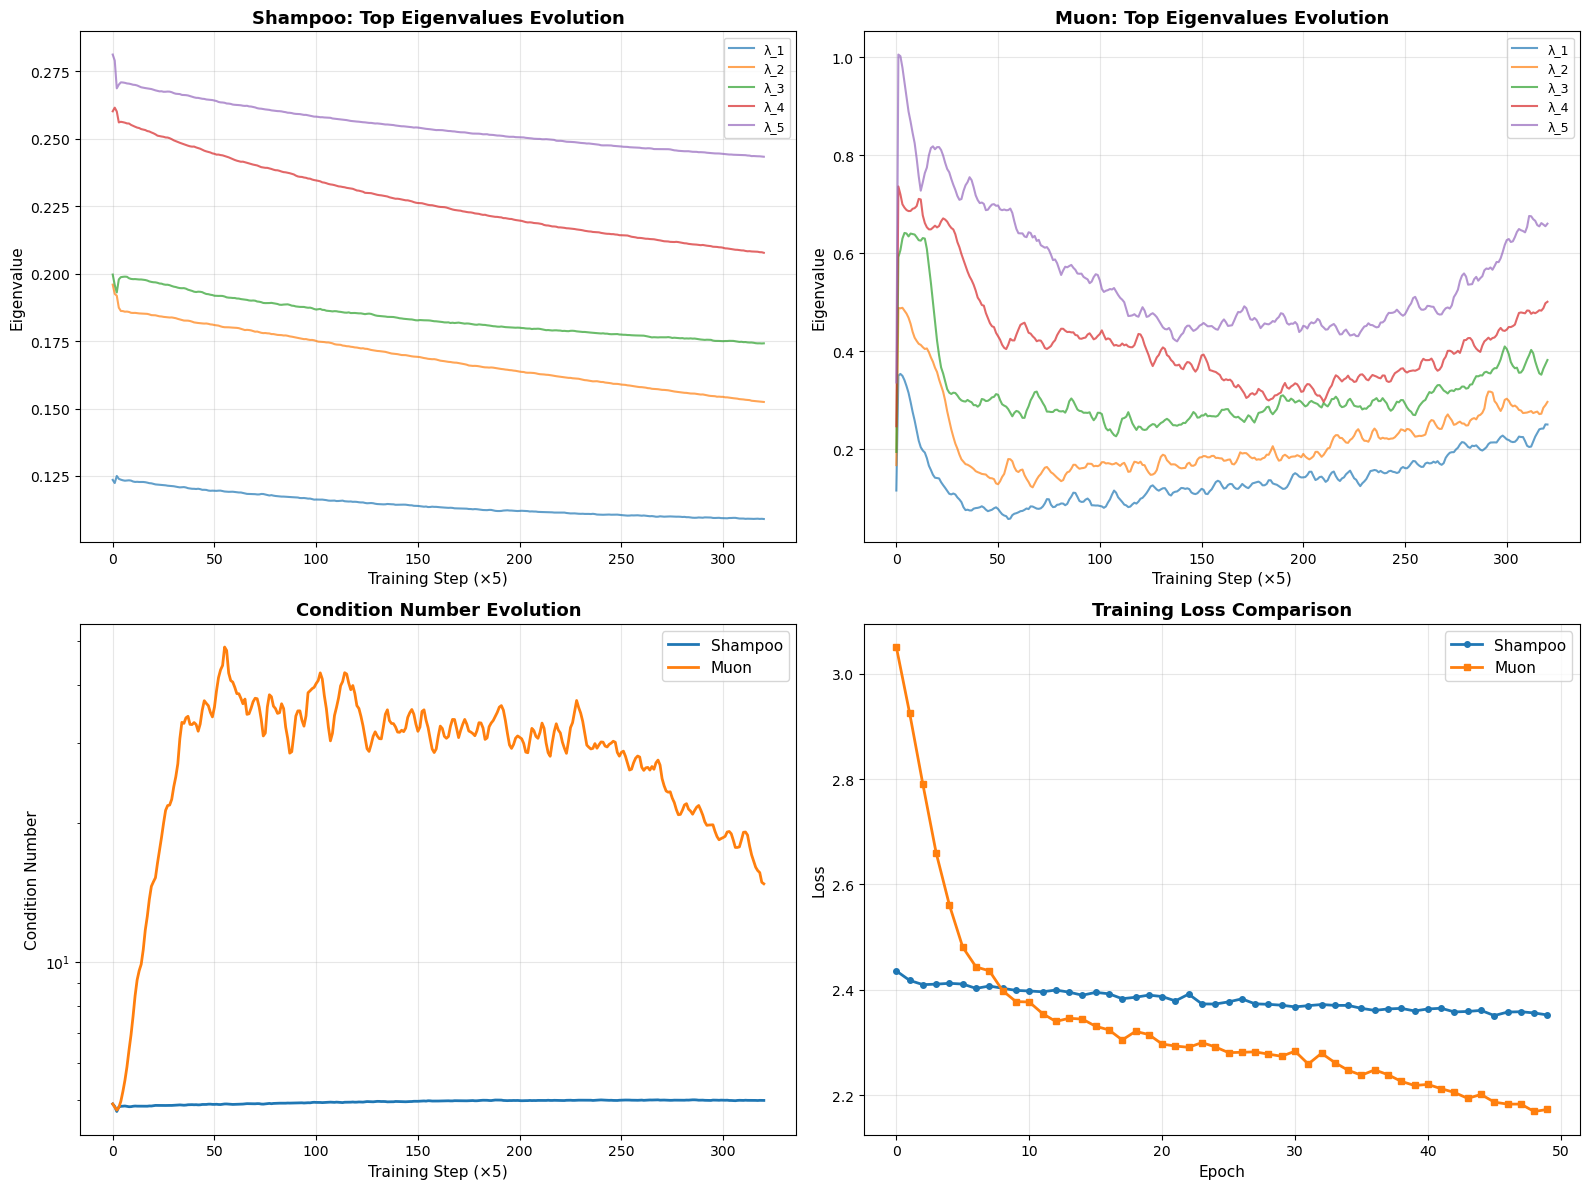


Visualization complete! Saved to 'eigenvalue_evolution.png'


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Eigenvalue evolution for Shampoo (all eigenvalues)
ax1 = axes[0, 0]
eigenvalues_shampoo_array = np.array(eigenvalues_shampoo)
for i in range(min(5, eigenvalues_shampoo_array.shape[1])):
    ax1.plot(eigenvalues_shampoo_array[:, i], label=f'λ_{i+1}', alpha=0.7)
ax1.set_xlabel('Training Step (×5)', fontsize=11)
ax1.set_ylabel('Eigenvalue', fontsize=11)
ax1.set_title('Shampoo: Top Eigenvalues Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Eigenvalue evolution for Muon (all eigenvalues)
ax2 = axes[0, 1]
eigenvalues_muon_array = np.array(eigenvalues_muon)
for i in range(min(5, eigenvalues_muon_array.shape[1])):
    ax2.plot(eigenvalues_muon_array[:, i], label=f'λ_{i+1}', alpha=0.7)
ax2.set_xlabel('Training Step (×5)', fontsize=11)
ax2.set_ylabel('Eigenvalue', fontsize=11)
ax2.set_title('Muon: Top Eigenvalues Evolution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Condition number evolution (ratio of max to min eigenvalue)
ax3 = axes[1, 0]
condition_shampoo = eigenvalues_shampoo_array.max(axis=1) / (eigenvalues_shampoo_array.min(axis=1) + 1e-10)
condition_muon = eigenvalues_muon_array.max(axis=1) / (eigenvalues_muon_array.min(axis=1) + 1e-10)
ax3.plot(condition_shampoo, label='Shampoo', linewidth=2)
ax3.plot(condition_muon, label='Muon', linewidth=2)
ax3.set_xlabel('Training Step (×5)', fontsize=11)
ax3.set_ylabel('Condition Number', fontsize=11)
ax3.set_title('Condition Number Evolution', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Training loss comparison
ax4 = axes[1, 1]
ax4.plot(loss_shampoo, label='Shampoo', linewidth=2, marker='o', markersize=4)
ax4.plot(loss_muon, label='Muon', linewidth=2, marker='s', markersize=4)
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Loss', fontsize=11)
ax4.set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eigenvalue_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization complete! Saved to 'eigenvalue_evolution.png'")


## Eigenvalue Spectrum Comparison


In [ ]:
# Plot eigenvalue spectra at different time points
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

time_points = [0, len(eigenvalues_shampoo)//2, -1]
time_labels = ['Initial', 'Mid-training', 'Final']

for idx, (time_idx, label) in enumerate(zip(time_points, time_labels)):
    ax = axes[idx]
    
    eig_shampoo = eigenvalues_shampoo[time_idx]
    eig_muon = eigenvalues_muon[time_idx]
    
    x = np.arange(len(eig_shampoo))
    width = 0.35
    
    ax.bar(x - width/2, sorted(eig_shampoo, reverse=True), width, label='Shampoo', alpha=0.7)
    ax.bar(x + width/2, sorted(eig_muon, reverse=True), width, label='Muon', alpha=0.7)
    
    ax.set_xlabel('Eigenvalue Index', fontsize=11)
    ax.set_ylabel('Eigenvalue Magnitude', fontsize=11)
    ax.set_title(f'{label} Eigenvalue Spectrum', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig('eigenvalue_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSpectrum comparison complete! Saved to 'eigenvalue_spectrum.png'")


## Summary Statistics


In [9]:
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

print("\nShampoo Optimizer:")
print(f"  Final Loss: {loss_shampoo[-1]:.6f}")
print(f"  Max Eigenvalue (final): {eigenvalues_shampoo[-1].max():.6f}")
print(f"  Min Eigenvalue (final): {eigenvalues_shampoo[-1].min():.6f}")
print(f"  Condition Number (final): {condition_shampoo[-1]:.2f}")
print(f"  Eigenvalue Spread: {eigenvalues_shampoo[-1].max() - eigenvalues_shampoo[-1].min():.6f}")

print("\nMuon Optimizer:")
print(f"  Final Loss: {loss_muon[-1]:.6f}")
print(f"  Max Eigenvalue (final): {eigenvalues_muon[-1].max():.6f}")
print(f"  Min Eigenvalue (final): {eigenvalues_muon[-1].min():.6f}")
print(f"  Condition Number (final): {condition_muon[-1]:.2f}")
print(f"  Eigenvalue Spread: {eigenvalues_muon[-1].max() - eigenvalues_muon[-1].min():.6f}")

print("\nComparison:")
if loss_shampoo[-1] < loss_muon[-1]:
    print(f"  ✓ Shampoo achieved lower final loss ({loss_shampoo[-1]:.6f} vs {loss_muon[-1]:.6f})")
else:
    print(f"  ✓ Muon achieved lower final loss ({loss_muon[-1]:.6f} vs {loss_shampoo[-1]:.6f})")

if condition_shampoo[-1] < condition_muon[-1]:
    print(f"  ✓ Shampoo has better conditioning ({condition_shampoo[-1]:.2f} vs {condition_muon[-1]:.2f})")
else:
    print(f"  ✓ Muon has better conditioning ({condition_muon[-1]:.2f} vs {condition_shampoo[-1]:.2f})")

print("\n" + "="*60)


SUMMARY STATISTICS

Shampoo Optimizer:
  Final Loss: 2.352040
  Max Eigenvalue (final): 0.543406
  Min Eigenvalue (final): 0.109046
  Condition Number (final): 4.98
  Eigenvalue Spread: 0.434360

Muon Optimizer:
  Final Loss: 2.172594
  Max Eigenvalue (final): 3.699681
  Min Eigenvalue (final): 0.250495
  Condition Number (final): 14.77
  Eigenvalue Spread: 3.449187

Comparison:
  ✓ Muon achieved lower final loss (2.172594 vs 2.352040)
  ✓ Shampoo has better conditioning (4.98 vs 14.77)

